# Lukas-Kanade Tracker

In [1]:
%matplotlib notebook
import cv2
import numpy as np
import copy
import time
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


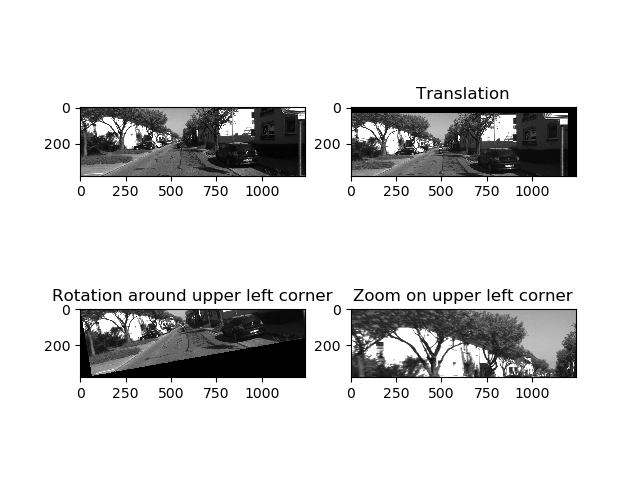

<IPython.core.display.Javascript object>


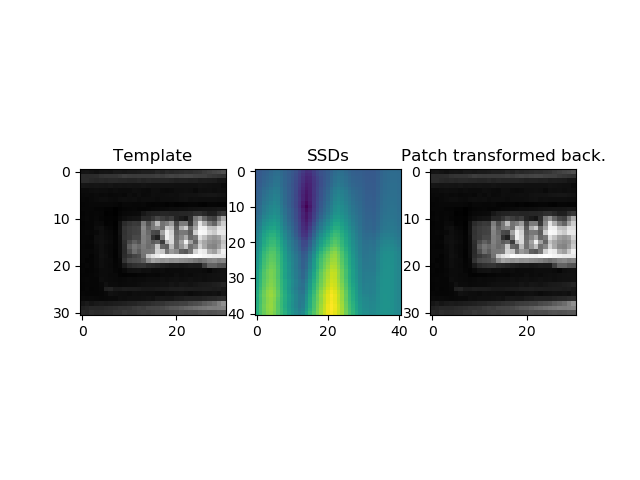

Minimum attained ad (10, 14), ssd=0.0
Displacement best explained by (dx dy) = [-10  -6]. Brute force took=0.9920351505279541 s.


In [2]:
def get_image(idx, downscale=None):
    I_R = cv2.imread(f"../data/{idx:06}.png", cv2.IMREAD_GRAYSCALE)
    if downscale:
        new_dim = np.array([I_R.shape[1]/downscale, I_R.shape[0]/downscale], dtype=int) 
        return cv2.resize(I_R, new_dim, interpolation = cv2.INTER_AREA)
    else:
        return I_R
    
def load_keypoints(downscale=1):
    keypoints = []
    with open("../data/keypoints.txt", 'r') as stream:
        for line in stream:
            keypoints.append([np.rint(int(x)/downscale) for x in line.split()])
    keypoints_rc =  np.asarray(keypoints, dtype=int).T
    # flip upside-down to have cols (x) and then rows (y) and keep first 50
    return np.flipud(keypoints_rc[:, :50]) 

def draw_keypoints(img, kpts):
    img_tmp = copy.deepcopy(img)
    img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_GRAY2RGB)
    
    # TODO(giuseppe) change this to use np array
    for j in range(kpts.shape[1]):
        cv2.drawMarker(img_tmp, (kpts[0, j], kpts[1, j]), (0, 255, 0), markerType=cv2.MARKER_STAR, markerSize=1, 
                       thickness=1)
    return img_tmp

def draw_matches(img, kpts_query, kpts_db, matches):
    img_tmp = copy.deepcopy(img)
    img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_GRAY2RGB)
    for i, m in enumerate(matches):
        if m !=-1:
            kptq = kpts_query[:, i]
            kptd = kpts_db[:, m]
            #print(f"keypoint query is {kptq}")
            #print(f"keypoint db is {kptq}")
            
            cv2.drawMarker(img_tmp, (kptq[0], kptq[1]), (0, 255, 0), cv2.MARKER_STAR, markerSize=1, 
                           thickness=2)
            cv2.drawMarker(img_tmp, (kptd[0], kptd[1]), (0, 255, 0), cv2.MARKER_STAR, markerSize=1, 
                           thickness=2)
            cv2.line(img_tmp, (kptd[0], kptd[1]), (kptq[0], kptq[1]), (0, 0, 255), thickness=1)
    return img_tmp


def convolve(img, kernel):
    # filter2D is just a correlation. Convolution requires a 180 kernel flip
    kernel = kernel[::-1, ::-1]
    
    # find half the dim of the filter and cut away unwanted information
    pad = np.floor(np.array(kernel.shape)/2).astype(int)
    img = cv2.filter2D(img, -1, kernel)
    
    # remove unwanted info and set the border to zero to get same dim
    img = img[pad[0]:-pad[0], pad[1]:-pad[1]]
    img = cv2.copyMakeBorder(img,top=pad[1],bottom=pad[1],left=pad[0],right=pad[0],
    borderType=cv2.BORDER_CONSTANT,value=0)
    return img

def gradient(I, axis='x', scale=1.0):
    # TODO(giuseppe) remeber that we inverted convention using here that x is cols and not rows
    sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_y = np.array([[1, 2,  1], [0, 0, 0], [-1, -2, -1]])
    
    if axis == 'x':
        return convolve(I.astype(float), sobel_x)/scale
    else:
        return convolve(I.astype(float), sobel_y)/scale

def plot_image(idx):
    fig, ax = plt.subplots()
    ax.imshow(get_image(idx), cmap='gray')

def get_sim_warp(dx, dy, alpha, scale):
    return scale * np.array([[np.cos(alpha), -np.sin(alpha), dx],
                             [np.sin(alpha),  np.cos(alpha), dy]])

def warp_image(I, W, center=(0, 0), rp=None, debug_print=False):
    """ Implements generic image wide and patch warping """
    h, w = I.shape
    
    # Since we do bilinear interpolation, we need a pixel after to compute it
    # (u+1 and v+1 need to be valid pixel locations)
    if rp:
        u_min, u_max = center[0] - rp, center[0] + rp
        v_min, v_max = center[1] - rp, center[1] + rp
        u, v = np.meshgrid(np.linspace(u_min, u_max, u_max-u_min+1, dtype=int), 
                           np.linspace(v_min, v_max, v_max-v_min+1, dtype=int))
        out_shape = (2*rp + 1, 2*rp + 1)
    else:
        u, v = np.meshgrid(np.linspace(0, w-2, w-1, dtype=int), np.linspace(0, h-2, h-1, dtype=int))
        out_shape = (h, w)
    
    I_new = np.zeros((h, w))
        
        
    u = u.reshape(1, -1)
    v = v.reshape(1, -1)
    
    # W is the matrix transforming a point in x and y where x is the matrix cols (u) and y is the matrix rows (v)
    # with the convention adopted in this function
    x = np.vstack((u-center[0], v-center[1], np.ones((1, u.size))))  

    x_new = W @ x
    u_new, v_new = x_new[0, :]+center[0], x_new[1, :]+center[1]
    
    outbound_mask = (u_new < 0) | (u_new >= w-1) | (v_new < 0) | (v_new >= h-1)
    outbound_idxs =  np.where(outbound_mask)
    
    # delete source and destination indexes that are out of the image bounds
    u = np.delete(u, outbound_idxs)
    v = np.delete(v, outbound_idxs)
    u_new = np.delete(u_new, outbound_idxs)
    v_new = np.delete(v_new, outbound_idxs)
    
    if debug_print:
        print(f"There are {100.0 * np.sum(outbound_mask).astype(np.float)/(h*w)} % of indexes out of bounds")
    
    u_appr = np.floor(u_new).astype(int)
    v_appr = np.floor(v_new).astype(int)
    
    delta_u = u_new - u_appr
    delta_v = v_new - v_appr
    
    # pixel v, u has the same intensity of circa the pixel v_appr, u_appr
    # in the original image. In other words, we are mapping pixel intensities to other intensities
    # in the original image at a transformed location
    
    # think to a pixel at the far boarder and a positive translation of 10 pixels
    # I'(x, y) = I(x+50, y) = 0 as there is no image info at x + 50
    # therefore the image will seem shifted back
    
    # -- bilinear interpolation --
    I_new[v, u] = I[v_appr, u_appr] * (1.0 - delta_v) * (1.0 - delta_u) + \
                  I[v_appr, u_appr+1] * (1.0 - delta_v) * delta_u + \
                  I[v_appr+1, u_appr] * (1.0 - delta_u) * delta_v + \
                  I[v_appr+1, u_appr+1] * delta_u * delta_v 
    
    if rp:
        patch = np.zeros(out_shape)
#         print(v)
#         print(u)
#         print(v-v_min)
#         print(u-u_min)
        patch[v - v_min, u - u_min] = I_new[v, u]
        return patch
    else:
        return I_new


def track_brute_force(I_R, I, p, rp, rs):
    """
    I_R: reference image
    I: image to track point in
    p: point to track
    rp: radius of the patch around point to track
    rs: radius of displacements to look for 
    
    return:
    dx: translation that best explains where p is in image I
    ssds: SSDs for all values of dx within the patch defined by center p and radius search_radius
    """
    W_0 = get_sim_warp(0, 0, 0, 1)
    template = warp_image(I_R, W_0, center=p, rp=rp)
            
    ssds = np.zeros((2*rs+1, 2*rs+1))
    for dx in range(-rs, rs+1):
        for dy in range(-rs, rs+1):
            W = get_sim_warp(dx, dy, 0, 1)
            candidate = warp_image(I, W, center=p, rp=rp)
            ssds[dx+rs, dy+rs] = np.sum(np.square(template - candidate))
    
    dx  = np.unravel_index(ssds.argmin(), ssds.shape)
    print(f"Minimum attained ad {dx}, ssd={ssds[dx[0], dx[1]]}")
    return np.array([dx[0] - rs, dx[1] - rs]), ssds
            

#####################

# Part 1: Warping images
I_R = get_image(0)

fig, ax = plt.subplots(2, 2)

ax[0][0].imshow(I_R, cmap='gray')

W = get_sim_warp(50, -30, 0, 1)
ax[0][1].imshow(warp_image(I_R, W), cmap='gray')
ax[0][1].set_title('Translation');

W = get_sim_warp(0, 0, 10 * np.pi / 180.0, 1)
ax[1][0].imshow(warp_image(I_R, W), cmap='gray')
ax[1][0].set_title('Rotation around upper left corner')

W = get_sim_warp(0, 0, 0, 0.5)
ax[1][1].imshow(warp_image(I_R, W), cmap='gray')
ax[1][1].set_title('Zoom on upper left corner')

#####################
#  Part 2: Warped patches and recovering a simple warp with brute force
I_R = get_image(0)

# Get and display template
fig, ax = plt.subplots(1, 3)
W0 = get_sim_warp(0, 0, 0, 1)
x_T = np.array([900, 291])
r_T = 15

template = warp_image(I_R, W0, x_T, r_T)
ax[0].imshow(template, cmap='gray')
ax[0].set_title('Template')


W = get_sim_warp(10, 6, 0, 1)
I = warp_image(I_R, W)
r_D = 20

import time
start = time.time()
dx, ssds = track_brute_force(I_R, I, x_T, r_T, r_D)
end = time.time()
ax[1].imshow(ssds)
ax[1].set_title('SSDs')

print(f"Displacement best explained by (dx dy) = {dx}. Brute force took={end-start} s.")

ax[2].imshow(warp_image(I, get_sim_warp(dx[0], dx[1], 0, 1), x_T, r_T), cmap='gray')
ax[2].set_title('Patch transformed back.');


### Recovering the warp with KLT

In [3]:
#TODO(giuseppe) check the ordering and the reshaping
def track_KLT(I_R, I, x_T, r_T, num_iters, gradient_scale=1.0, do_plot=False, debug=False):
    
    """
    I_R: reference image
    I: image to track point in
    x_T: point to track expressed as [x y] = [col row]
    r_T: radius of patch to track
    num_iters: amount of iterations to run
    gradient_scale: scale the gradient to avoid overshooting
    
    return:
    W: final W estimate
    p_hist: 6 x (num_iters +1) history of p estimates including the initial identity estimate
    """
    
    tolerance_reached = False
    

    W = get_sim_warp(0, 0, 0, 1)
    template = warp_image(I_R, W, x_T, r_T)
    i_R = template.reshape(-1)
    
    p_hist = np.zeros((6, num_iters+1))
    p_hist[:, 0] = W.reshape(-1)
    
    # patch coordinate wrt to patch center
    xs = np.arange(-r_T, r_T+1)
    ys = np.arange(-r_T, r_T+1)
    n = len(xs)
    o = np.ones((1, n))
    
    xy1 = np.hstack((np.kron(o, xs).T, 
                     np.kron(ys, o).T, 
                     np.ones((n*n, 1))))
    dw_dp = np.kron(xy1, np.eye(2))
                    
    # allocate memory
    di_dp = np.zeros((n*n, 6))
    
#     print(f"di_dp shape is: {di_dp.shape}")
#     print(f"dw_dp shape is: {dw_dp.shape}")
    
    if do_plot:
        fig1, ax1 = plt.subplots(1, 3)
        fig2, ax2 = plt.subplots(1, 2)
        fig3, ax3 = plt.subplots()
        
    for k in range(1, num_iters+1):
        Ip = warp_image(I, W, x_T, r_T) 
        i = Ip.reshape(-1)
        
        di_dx = gradient(Ip, axis='x', scale=gradient_scale).reshape(-1)
        di_dy = gradient(Ip, axis='y', scale=gradient_scale).reshape(-1)
        di_dw = np.vstack((di_dx, di_dy)).T
        
        for pixel_i in range(n*n):
            di_dp[pixel_i, :] = di_dw[pixel_i, :] @ dw_dp[pixel_i*2:(pixel_i+1)*2, :]
    
        # hessian
        H = di_dp.T @ di_dp
        
        # putting together and incrementing
        delta_p = np.linalg.solve(H, di_dp.T @ (i_R - i))
        
        # the adopted convention order params in colwise format
        # namely
        # W = [a1 a3 a5 
        #      a2 a4 a6]
        dW = delta_p.reshape((2, 3), order='F')
        W = W + dW
                            
        # compute new W 
        p_hist[:, k] = W.reshape(-1)
        
        if np.linalg.norm(delta_p) < 1e-3:
            p_hist = p_hist[:, 1:k+1]
            tolerance_reached = True
            if debug:
                print(f"Early break: stopping at iteration {k} with delta_p={np.linalg.norm(delta_p)}")
        
        if do_plot and (k == num_iters or tolerance_reached):
            ax1[0].imshow(template, cmap='gray')
            ax1[0].set_title('Template')

            ax1[1].imshow(Ip, cmap='gray')
            ax1[1].set_title('Warped patch')

            diff = ax1[2].imshow(template - Ip)
            ax1[2].set_title('Difference')
            fig1.colorbar(diff, ax=ax1[2])

            ax2[0].imshow(di_dx.reshape(Ip.shape))
            ax2[0].set_title('Warped Ix')

            grad = ax2[1].imshow(di_dy.reshape(Ip.shape))
            ax2[1].set_title('Warped Iy')
            fig2.colorbar(grad, ax=ax2[1])

            steepest_descent = np.zeros((n, 6*n))
            for j in range(6):
                steepest_descent[:, j*n : (j+1)*n] = di_dp[:, j].reshape((n,n))
            steepest = ax3.imshow(steepest_descent)
            ax3.set_title('Steepest descent images')
            fig3.colorbar(steepest, ax=ax3)
        
        if tolerance_reached:
            break
    
    return W, p_hist


def track_KLT_robustly(I_prev, I, keypoint, r_T, num_iters, gradient_scale, gamma=None):
    """
    I_prev: reference image
    I: image to track point in
    keypoint: point to track
    r_t: radius of patch to track
    num_iters: amount of iterations to run
    gamma: bidirectional error threshold
    
    return
    delta_keypoint: delta by which the keypoint has moved between images (2x1)
    keep: true if the point tracking has passed the bidirectional error test
    
    """
    if gamma is None:
        W, p_hist = track_KLT(I_prev, I, keypoint, r_T, num_iters, gradient_scale)
        return W, p_hist, True
    else:
        W, p_hist = track_KLT(I_prev, I, keypoint, r_T, num_iters, gradient_scale)
        delta_keypoint = W[:, -1]
        
        new_kpt = np.rint(keypoint + delta_keypoint).astype(int)
        Winv, _ = track_KLT(I, I_prev, new_kpt, r_T, num_iters, gradient_scale)
        
        dkpinv = Winv[:, -1]
        keep = np.linalg.norm(delta_keypoint + dkpinv) < gamma
    
    return W, p_hist, keep

## Recovering warp with KLT

<IPython.core.display.Javascript object>


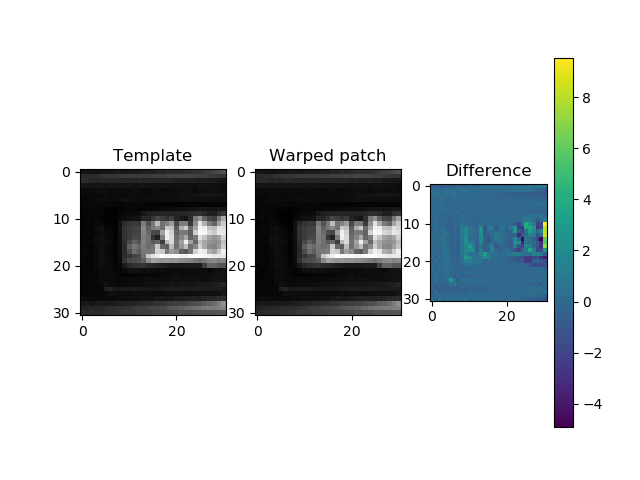

<IPython.core.display.Javascript object>


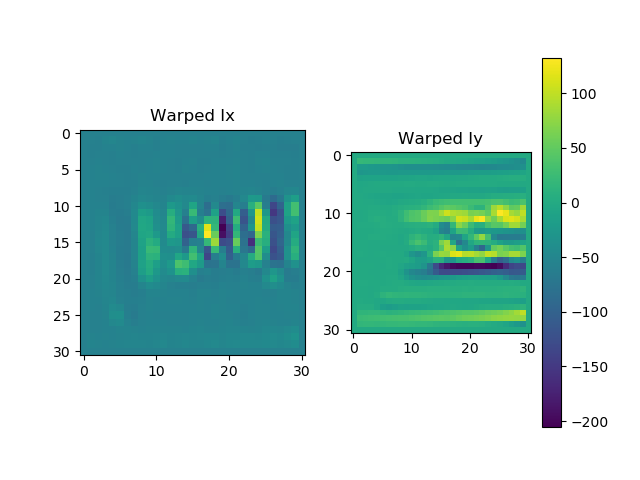

<IPython.core.display.Javascript object>


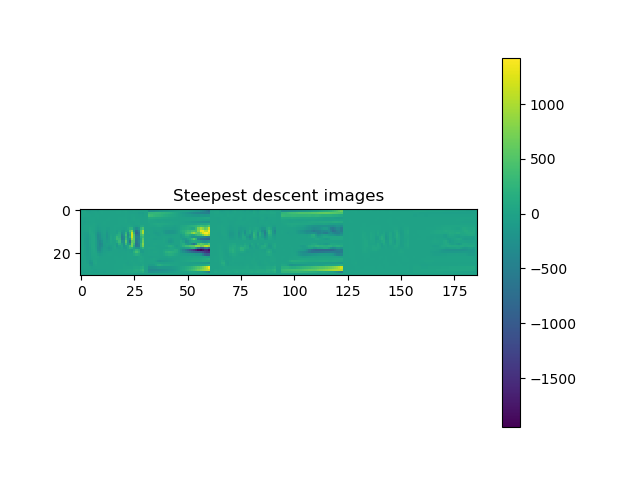

Point moved by
[[ 1.00309630e+00  1.10746669e-05 -1.00120245e+01]
 [-1.23621913e-03  1.00025197e+00 -5.99685160e+00]]
Should move by
[[ -1.   0. -10.]
 [ -0.  -1.  -6.]]


In [4]:
I_R = get_image(0)
x_T = np.array([900, 291])
r_T = 15
num_iters = 50
W = get_sim_warp(10, 6, 0, 1)
I = warp_image(I_R, W)

W_est, p_hist = track_KLT(I_R, I, x_T, r_T, num_iters, gradient_scale=4, do_plot=True, debug=True)

print(f"Point moved by\n{W_est}")
print(f"Should move by\n{-W}")

## Applying KLT to Kitti

In [8]:
from matplotlib.animation import FuncAnimation
from IPython import display

import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()
                                                
# variables
keypoints = load_keypoints(downscale=4)
r_T = 15
num_iters = 50

def init():
    print("Initializing animation")

# With this we should not expect all points to be correctly tracked
def klt_kitti(frame_num, ax_prev, ax_next):
    global r_T
    global num_iters
    global keypoints
    
    I1 = get_image(frame_num, downscale=4) 
    I2 = get_image(frame_num+1, downscale=4)
    
    delta_keypoints = np.zeros(keypoints.shape)
    
    keep = [True for i in range(keypoints.shape[1])]
    for j in range(keypoints.shape[1]):
        # set gamma to None if no robust tracking is tested
        # gamma = None
        W, p_hist, valid = track_KLT_robustly(I1, I2, keypoints[:, j], r_T, num_iters, 
                                              gradient_scale=4.0, gamma=0.1)
        
        # the keypoint is at the center of the patch -> it only translates
        delta_keypoints[:, j] = W[:, -1] 
        keep[j] = valid
        
    kpold = copy.deepcopy(keypoints[:, keep])
    keypoints = np.rint(keypoints[:, keep] + delta_keypoints[:, keep]).astype(int, copy=False)

    I1 = draw_keypoints(I1, kpold)
    I2 = draw_matches(I2, keypoints, kpold, matches=np.arange(0, keypoints.shape[1]))
    
    ax_prev.imshow(I1)
    ax_next.imshow(I2)
    

# turn-off matplotlib in notebook plot
plt.ioff()
fig, ax = plt.subplots(2,1)
ax[0].set_title("Previous image")
ax[1].set_title("Next image")

anim = FuncAnimation(fig, klt_kitti, init_func=init, frames=20, interval=1000, fargs=(ax[0], ax[1]))
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()


Initializing animation
